In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=16, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def cspace_convert(img, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)
    return feature_image
    
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img)
    if len(bboxes) == 0:
        return draw_img
    for box in bboxes:
        if color == 'random':
            color_apply = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        else:
            color_apply = color
        cv2.rectangle(draw_img, box[0], box[1], color_apply, thick)
    return draw_img

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

In [3]:
def extract_features(imgs, cspace='RGB', spatial_size=(16, 16), hist_bins=16, orient=11, 
                    pix_per_cell=8, cell_per_block=2, hog_channel='ALL', hist_range=(0, 1), 
                    spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        feature_image = cspace_convert(image, cspace=cspace) 
        
        img_features = []
        
        if spatial_feat == True:
        #3) Compute spatial features if flag is set 
            spatial_features = bin_spatial(feature_image, size=(16, 16))
            img_features.append(spatial_features)

        if hist_feat == True:
        #5) Compute histogram features if flag is set
            hist_features = color_hist(feature_image, nbins=16, bins_range=hist_range)
            img_features.append(hist_features)

        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=False))

                hog_features = np.ravel(hog_features)   

            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            img_features.append(hog_features)
        
        features.append(np.concatenate(img_features))

    # Return list of feature vectors
    return features

In [4]:
car_images = []
noncar_images = []

car_images = glob.glob('./test_images/vehicles/**/*.png')
noncar_images = glob.glob('./test_images/non-vehicles/**/*.png')

print(len(car_images), len(noncar_images))


8792 8968


In [5]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16)
hist_bins=16
hist_range=(0, 1)
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(car_images, cspace=colorspace, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, hist_range=hist_range, 
                                spatial_feat=True, hist_feat=True, hog_feat=True)

notcar_features = extract_features(noncar_images, cspace=colorspace, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, hist_range=hist_range, 
                                spatial_feat=True, hist_feat=True, hog_feat=True)

In [6]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
X_scaler = StandardScaler().fit(X_train)

X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [7]:
# Use a linear SVC 
svc = LinearSVC()

svc.fit(X_train, y_train)

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

n_predict = 20
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

Test Accuracy of SVC =  0.9876
My SVC predicts:  [ 0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  1.  1.  1.  1.  1.  0.  0.  1.
  0.  0.]
For these 20 labels:  [ 0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  1.  1.  1.  1.  1.  0.  0.  1.
  0.  0.]


In [8]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, svc, X_scaler, ystart=400, ystop=700, scale=1, cspace='RGB', hog_channel='ALL', 
              orient=11, pix_per_cell=8, cell_per_block=2, 
              spatial_size=(16, 16), hist_bins=16, hist_range=(0, 1)):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    ctrans_tosearch = cspace_convert(img_tosearch, cspace=cspace) 
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64 
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2   # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]#.ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]#.ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]#.ravel() 
                #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                hog_features = np.ravel([hog_feat1, hog_feat2, hog_feat3])
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            
            img_features = []

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            img_features.append(spatial_features)
            
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)
            img_features.append(hist_features)
            
            img_features.append(hog_features)
            
            test_features = X_scaler.transform((np.concatenate([spatial_features, hist_features, hog_features])).reshape(1, -1)) 
            
            test_prediction = svc.predict(test_features)  #.reshape(1, -1)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

7 rectangles found in image


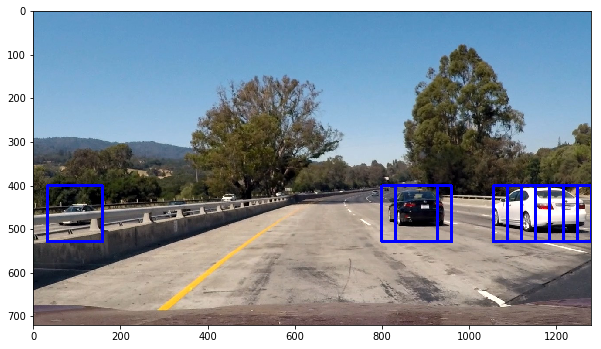

In [9]:
test_img = mpimg.imread('./test_images/test1.jpg')
#test_img = mpimg.imread('./test_images/bbox-example-image.jpg')

ystart = 400
ystop = 700
scale = 2
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16)
hist_bins=16
hist_range=(0, 1)
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


rectangles = find_cars(test_img, svc, X_scaler, ystart=ystart, ystop=ystop, scale=scale, cspace=colorspace, 
                       hog_channel=hog_channel, orient=orient, pix_per_cell=pix_per_cell, 
                       cell_per_block=cell_per_block, spatial_size=spatial_size, 
                       hist_bins=hist_bins, hist_range=hist_range)

print(len(rectangles), 'rectangles found in image')

test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

Number of boxes:  18


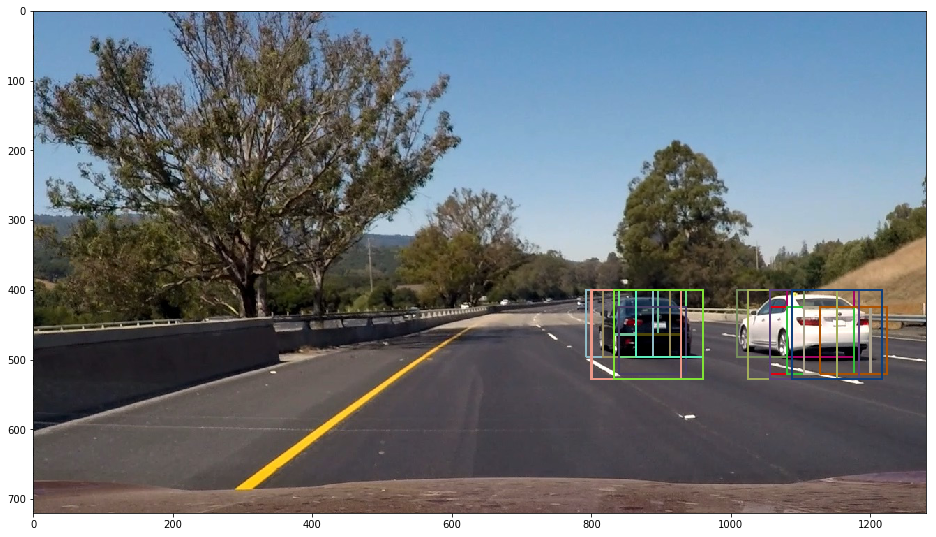

In [10]:
#test_img = mpimg.imread('./test_images/bbox-example-image.jpg')
test_img = mpimg.imread('./test_images/test6.jpg')

rectangles = []

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16)
hist_bins=16
hist_range=(0, 1)
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

ystart = 400
ystop = [480, 528, 560, 660]
#ystop = [700, 700, 700, 700]
scale = [1.0, 1.5, 2.0, 3.5]

for i in range(len(ystop)):
    rectangles.append(find_cars(test_img, svc, X_scaler, ystart=ystart, ystop=ystop[i], scale=scale[i], cspace=colorspace, 
                       hog_channel=hog_channel, orient=orient, pix_per_cell=pix_per_cell, 
                       cell_per_block=cell_per_block, spatial_size=spatial_size, 
                       hist_bins=hist_bins, hist_range=hist_range)
                     )

rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)

plt.figure(figsize=(16,16))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

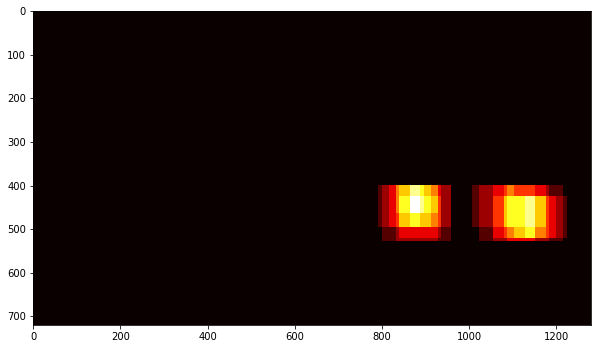

In [11]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

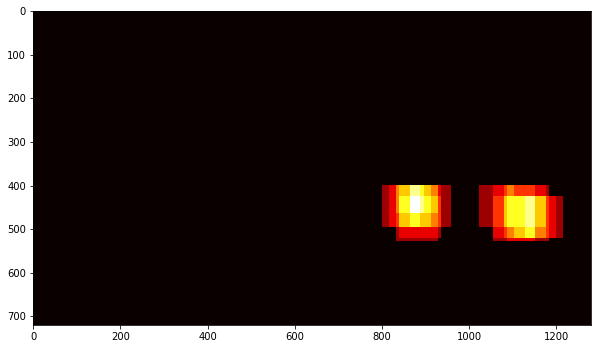

In [12]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

2 cars found


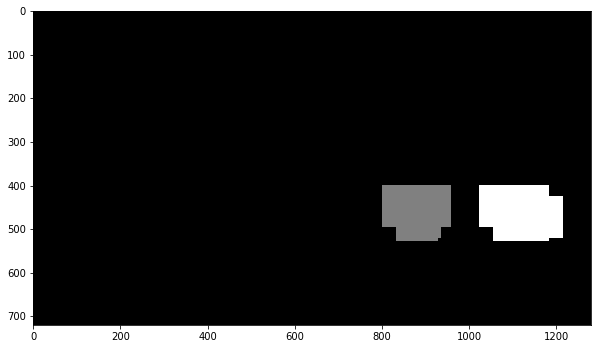

In [13]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

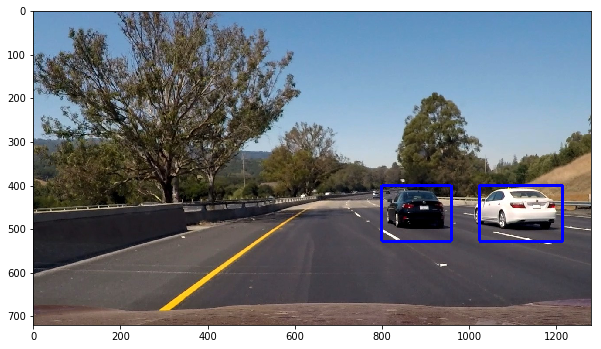

In [14]:
# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [15]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 10:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

In [16]:
def process_frame_for_video(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    spatial_size = (16, 16)
    hist_bins=16
    hist_range=(0, 1)
    orient = 11
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 400
    ystop = [480, 528, 560, 660]
    #ystop = [700, 700, 700, 700]
    scale = [1.0, 1.5, 2.0, 3.5]

    for i in range(len(ystop)):
        rectangles.append(find_cars(img, svc, X_scaler, ystart=ystart, ystop=ystop[i], scale=scale[i], cspace=colorspace, 
                       hog_channel=hog_channel, orient=orient, pix_per_cell=pix_per_cell, 
                       cell_per_block=cell_per_block, spatial_size=spatial_size, 
                       hist_bins=hist_bins, hist_range=hist_range)
                     )
 
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [17]:
det = Vehicle_Detect()

cap = cv2.VideoCapture('./project_video.mp4')
#cap = cv2.VideoCapture('./test_video.mp4')

while(cap.isOpened()):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    processed_img = cv2.cvtColor(process_frame_for_video(frame), cv2.COLOR_RGB2BGR)
    cv2.imshow('frame', processed_img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
det = Vehicle_Detect()

test_out_file2 = './project_video_out1_undist.mp4'
clip_test2 = VideoFileClip('./project_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_for_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

In [19]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(abs_sobel * 255 / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    mag = np.sqrt(sobelx**2 + sobely**2)
    mag = np.uint8(mag * 255 / np.max(mag))
    mag_binary = np.zeros_like(mag)
    mag_binary[(mag >= mag_thresh[0]) & (mag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return dir_binary

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = HLS[:,:,2]
    L = HLS[:,:,1]
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(L)
    binary_output[(L > thresh[0]) & (L <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary_output

def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    #if np.max(lab_b) > 175:
    #    lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def combined_binary(image):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(15, 150))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3)) #np.pi/3

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) | (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    gradient_binary = combined
    
    hls_binary = hls_select(image, thresh=(170, 255))
    lab_binary = lab_bthresh(image, thresh=(133, 255))
    
    combined_binary = np.zeros_like(hls_binary)
    combined_binary[(hls_binary == 1) | (lab_binary == 1)] = 1
    return combined_binary

def undistroted(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [20]:
def warpPerspective_from_img(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1],gray.shape[0])

    src = np.float32(
        [[(img_size[0] / 2) - 58, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 0), img_size[1]-10],
        [(img_size[0] * 5 / 6) + 48, img_size[1]-10],
        [(img_size[0] / 2 + 64), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    #Minv = np.linalg.inv(M)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR), Minv

In [21]:
# Fit the line for the 1st time or no good fit can be carried over from last frame

def new_fit(image):
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    
    # Set the width of the windows +/- margin
    margin = 80

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    line_pixels = [leftx, lefty, rightx, righty]
    
    return left_fit, right_fit, line_pixels

In [22]:
# Fit the line if good fit is detected in last frame

def carry_over_fit(image, left_fit_prev, right_fit_prev):
    # Set the width of the windows +/- margin
    margin = 80

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    win_x_left = left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2]
    win_x_right = right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2]
    
    left_lane_inds = ((nonzerox > (win_x_left - margin)) & (nonzerox < (win_x_left + margin))) 
    right_lane_inds = ((nonzerox > (win_x_right - margin)) & (nonzerox < (win_x_right + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    line_pixels = [leftx, lefty, rightx, righty]
    
    return left_fit, right_fit, line_pixels

In [23]:
# Put the process warp image back to original image

def warpPerspective_to_img(image, image_original, left_fit, right_fit, line_pixels, Minv):

    if left_fit is None or right_fit is None:
        return image_original
    
    # Create an image to draw the lines on
    else:
        out_img = np.dstack((image, image, image))*255
        window_img = np.zeros_like(out_img)

        window_img[line_pixels[1], line_pixels[0]] = [255, 0, 0]
        window_img[line_pixels[3], line_pixels[2]] = [0, 0, 255]

        ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([pts]), (0,255, 0))

        newwarp = cv2.warpPerspective(window_img, Minv, (image_original.shape[1], image_original.shape[0]))
        return cv2.addWeighted(image_original, 0.8, newwarp, 0.3, 0)

In [24]:
# Calculation of curvature and offset based on fit coefficients 

def cal_curverad_offset(image, left_fit, right_fit, line_pixels):
    left_curverad, right_curverad, offset = (0, 0, 0)
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    if len(line_pixels[1]) != 0 and len(line_pixels[2]) != 0 and len(line_pixels[2]) != 0 and len(line_pixels[3]) != 0:
        left_fit_cr = np.polyfit(line_pixels[1]*ym_per_pix, line_pixels[0]*xm_per_pix, 2)
        right_fit_cr = np.polyfit(line_pixels[3]*ym_per_pix, line_pixels[2]*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    if left_fit is not None and right_fit is not None:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        offset = ((right_fitx[-1] + left_fitx[-1])/2 - image.shape[1]/2)*xm_per_pix
    
    return left_curverad, right_curverad, offset

In [25]:
# Plot the curvature and offset on final processed image

def plot_text(image, left_curverad, right_curverad, offset):
    text = 'Radius of Curvature = {}(m)'.format(int((left_curverad + right_curverad)/2))
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image,text,(50,60), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    
    if offset > 0:
        offset_side = 'left'
    else:
        offset_side = 'right'
        
    text = 'Vehicle is {:0.2f}m {} of the center'.format(abs(offset), offset_side)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image,text,(50,120), font, 1.5,(255,255,255),2,cv2.LINE_AA)

In [26]:
# Plot the fit lines in processing with monitoring 

def plot_fit(image, left_fit, right_fit, color = (255,255,0)):
    if left_fit is None and right_fit is None:
        return image

    else:
        new_image = np.copy(image)
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
        if left_fit is not None:            
            plotx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
            cv2.polylines(new_image, np.int32([pts]), isClosed=False, color=color, thickness=8)
        if right_fit is not None:            
            plotx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
            cv2.polylines(new_image, np.int32([pts]), isClosed=False, color=color, thickness=8)
    return new_image

In [27]:
# Define a class to receive the characteristics of each line detection

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False     
        
        #polynomial coefficients of the last n iterations
        self.recent_fits = []
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
    def add_fit(self, fit):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.recent_fits) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                #self.px_count = np.count_nonzero(inds)
                self.recent_fits.append(fit)
                if len(self.recent_fits) > 5:
                    # throw out old fits, keep newest n
                    self.recent_fits = self.recent_fits[len(self.recent_fits)-5:]
                self.best_fit = np.average(self.recent_fits, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.recent_fits) > 0:
                # throw out oldest fit
                self.recent_fits = self.recent_fits[1:len(self.recent_fits)]
            if len(self.recent_fits) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.recent_fits, axis=0)

In [28]:
# Image processing pipeline

def process_image(image):

    #image = np.fliplr(image)
    #img_undistroted = undistroted(image)
    img_undistroted = np.copy(image)
    
    warped, Minv = warpPerspective_from_img(img_undistroted)
    image_from_combined_binary = combined_binary(warped)
    
    if not left_history.detected or not right_history.detected:
        left_fit, right_fit, line_pixels = new_fit(image_from_combined_binary)
    else:
        left_fit, right_fit, line_pixels = carry_over_fit(image_from_combined_binary, left_history.best_fit, right_history.best_fit)
    
    left_history.add_fit(left_fit)
    right_history.add_fit(right_fit)
    
    left_curverad, right_curverad, offset = cal_curverad_offset(image_from_combined_binary, left_history.best_fit, right_history.best_fit, line_pixels)
    #left_curverad, right_curverad, offset = cal_curverad_offset(image_from_combined_binary, left_fit, right_fit, line_pixels)
    
    result = warpPerspective_to_img(image_from_combined_binary, img_undistroted, left_history.best_fit, right_history.best_fit, line_pixels, Minv)
    #result = warpPerspective_to_img(image_from_combined_binary, img_undistroted, left_fit, right_fit, line_pixels, Minv)
    
    plot_text(result, left_curverad, right_curverad, offset)
    
    return result

In [29]:
def proc_veh_lane_detection(image):
    image = cv2.undistort(image, mtx, dist, None, mtx)
    
    image_copy = np.copy(image)
    #image_copy = cv2.undistort(image_copy, mtx, dist, None, mtx)
    
    warped, Minv = warpPerspective_from_img(image_copy)
    image_from_combined_binary = combined_binary(warped)
    
    if not left_history.detected or not right_history.detected:
        left_fit, right_fit, line_pixels = new_fit(image_from_combined_binary)
    else:
        left_fit, right_fit, line_pixels = carry_over_fit(image_from_combined_binary, left_history.best_fit, right_history.best_fit)
    
    left_history.add_fit(left_fit)
    right_history.add_fit(right_fit)
    
    left_curverad, right_curverad, offset = cal_curverad_offset(image_from_combined_binary, left_history.best_fit, right_history.best_fit, line_pixels)
    #left_curverad, right_curverad, offset = cal_curverad_offset(image_from_combined_binary, left_fit, right_fit, line_pixels)
    
    result = warpPerspective_to_img(image_from_combined_binary, image_copy, left_history.best_fit, right_history.best_fit, line_pixels, Minv)
    #result = warpPerspective_to_img(image_from_combined_binary, img_undistroted, left_fit, right_fit, line_pixels, Minv)
    
    plot_text(result, left_curverad, right_curverad, offset)
    
    
    
    image_copy1 = np.copy(image)
    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    spatial_size = (16, 16)
    hist_bins=16
    hist_range=(0, 1)
    orient = 11
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 400
    ystop = [480, 528, 560, 660]
    #ystop = [700, 700, 700, 700]
    scale = [1.0, 1.5, 2.0, 3.5]

    for i in range(len(ystop)):
        rectangles.append(find_cars(image_copy1, svc, X_scaler, ystart=ystart, ystop=ystop[i], scale=scale[i], cspace=colorspace, 
                       hog_channel=hog_channel, orient=orient, pix_per_cell=pix_per_cell, 
                       cell_per_block=cell_per_block, spatial_size=spatial_size, 
                       hist_bins=hist_bins, hist_range=hist_range)
                     )
 
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(image_copy1[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 2 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    result1, rect = draw_labeled_bboxes(result, labels)
    
    return result1
    

In [30]:
file_Name = "data_package.pckl"
fileObject = open(file_Name,'rb') 
mtx, dist,car_features, notcar_features, X_scaler, svc = pickle.load(fileObject)

In [31]:
# Processing on a video

left_history = Line()
right_history = Line()
det = Vehicle_Detect()

#cap = cv2.VideoCapture('./project_video.mp4')
cap = cv2.VideoCapture('./test_video.mp4')
#cap = cv2.VideoCapture('./challenge_video.mp4')

while(cap.isOpened()):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #processed_img = cv2.cvtColor(process_image(frame), cv2.COLOR_RGB2BGR)
    processed_img = cv2.cvtColor(proc_veh_lane_detection(frame), cv2.COLOR_RGB2BGR)
    cv2.imshow('frame', processed_img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
left_history = Line()
right_history = Line()
det = Vehicle_Detect()

test_out_file = './project_video_out_combined_undistort.mp4'
clip_test = VideoFileClip('./project_video.mp4')
clip_test_out = clip_test.fl_image(proc_veh_lane_detection)
#clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)